In [140]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
class GCNLayer(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out)

    def forward(self, node_feats, adj_matrix):
        """
        Args:
            node_feats: Tensor with node features of shape [batch_size, num_nodes, c_in]
            adj_matrix: Batch of adjacency matrices of the graph. If there is an edge from i to j,
                         adj_matrix[b,i,j]=1 else 0. Supports directed edges by non-symmetric matrices.
                         Assumes to already have added the identity connections.
                         Shape: [batch_size, num_nodes, num_nodes]
        """
        # Num neighbours = number of incoming edges
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
        node_feats = self.projection(node_feats)
        node_feats = torch.bmm(adj_matrix, node_feats) #batch matrix matrix multiplication
        node_feats = node_feats / num_neighbours
        return node_feats

In [6]:
node_features = torch.arange(8, dtype=torch.float32).view(1,4,2)
adj_mat = torch.Tensor([[[1, 1, 0, 0], [1, 1, 1, 1], [0, 1, 1, 1], [0, 1, 1, 1]]])

In [7]:
with torch.no_grad():    
    x = nn.Linear(2, 2)(node_features)

In [56]:
(adj_mat.squeeze() == 1).nonzero().numpy().shape

(12, 2)

In [9]:
G = nx.Graph()
#This is the most unholy way to transforms the adj. matx. to connections
G.add_edges_from((adj_mat.squeeze() == 1).nonzero().numpy())

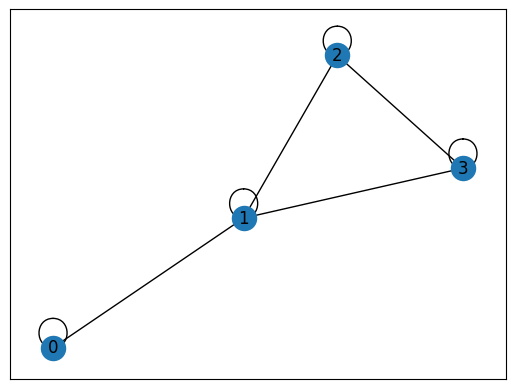

In [10]:
nx.draw_networkx(G) # viz the graph

#### Lets try to understand how GC works.
<br> 1. Build a GC layer
<br> 2. Initialize the layer weights and biases manually. 
<br> 3. Layer weights are initialized using an identity function
<br> 4. Biases are set to zero

In [11]:
layer = GCNLayer(c_in=2,c_out=2)
layer.projection.weight.data = torch.Tensor([[1.0, 0.0], [0.0, 1.0]])
layer.projection.bias.data = torch.Tensor([0.0, 0.0])


Look at th output of the graph convolution layer


In [216]:
layer(node_features,adj_mat)

tensor([[[1., 2.],
         [3., 4.],
         [4., 5.],
         [4., 5.]]], grad_fn=<DivBackward0>)

Lets look at a graph classification problem using an example chemical structure dataset available in pytorch geometric datasets

In [72]:
import torch_geometric.nn as geom_nn
from torch_geometric import data

In [24]:
tu_dataset = torch_geometric.datasets.TUDataset(root='./', name="MUTAG")

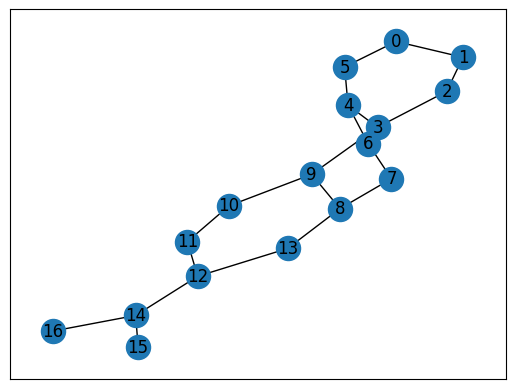

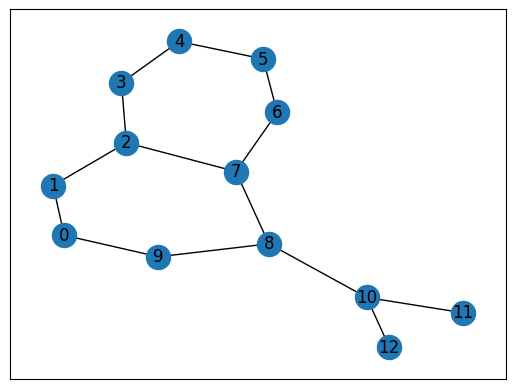

In [215]:
for i in range(2):   
    G=nx.Graph()
    G.add_edges_from(tu_dataset[i].edge_index.T.numpy())
    nx.draw_networkx(G)
    plt.show()

In [201]:
torch.manual_seed(42)
tu_dataset.shuffle()
train_dataset = tu_dataset[:150]
val_dataset = tu_dataset[150:180]
test_dataset = tu_dataset[180:]

In [202]:
BATCH_SIZE=16

In [203]:
graph_train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
graph_val_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE)  # Additional loader for a larger datasets
graph_test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

/Users/javis/miniconda3/envs/torch/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [99]:
batch = next(iter(graph_test_loader))
print("Batch:", batch)
print("Labels:", batch.y[:10])
print("Batch indices:", batch.batch[:40])

Batch: DataBatch(edge_index=[2, 660], x=[297, 7], edge_attr=[660, 4], y=[16], batch=[297], ptr=[17])
Labels: tensor([1, 1, 1, 0, 0, 0, 1, 1, 1, 0])
Batch indices: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2])


In [167]:
class GNNModel(nn.Module):
    def __init__(self, c_in=7,c_hidden=26, c_out=1):
        super().__init__()
        self.projection = geom_nn.GCNConv(c_in, c_hidden)
        self.head = nn.Sequential(nn.Dropout(0.1), nn.Linear(c_hidden, c_out))


    def forward(self, x, edge_index, batch_idx):
        x = self.projection(x, edge_index)
        x = geom_nn.global_mean_pool(x, batch_idx) 
        x = self.head(x)
        return x

In [217]:
class GraphLevelGNN(): 
    def __init__(self, **model_kwargs):
        super().__init__()
    
        self.history = {'loss':[],'val-loss':[],'epoch':[],'acc':[], 'val-acc':[]}
        self.c_out = 1
        self.loss = 0
        self.current_epoch = 0
        self.model = GNNModel(**model_kwargs)
        self.optimizer = optim.AdamW(self.model.parameters(), lr=1e-2, weight_decay=0.0)
        self.loss_module = nn.BCEWithLogitsLoss() if self.c_out == 1 else nn.CrossEntropyLoss()

    def forward(self, data, mode="train"):
        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
        if mode == "train":
            self.optimizer.zero_grad()
            self.model.train = True
            y_hat = self.model(x, edge_index, batch_idx)
            y_hat = y_hat.squeeze(dim=-1)

            if self.c_out == 1:
                preds = (y_hat > 0).float()
                data.y = data.y.float()
            else:
                preds = y_hat.argmax(dim=-1)
            loss = self.loss_module(y_hat, data.y)
            loss.backward()
            self.optimizer.step()
        else:
            with torch.no_grad():
                y_hat = self.model(x, edge_index, batch_idx)
                y_hat = y_hat.squeeze(dim=-1)

                if self.c_out == 1:
                    preds = (y_hat > 0).float()
                    data.y = data.y.float()
                else:
                    preds = y_hat.argmax(dim=-1)
                loss = self.loss_module(y_hat, data.y)

        acc = (preds == data.y).sum().float() / preds.shape[0]
        return loss, acc


    def training_step(self, batch):
        loss, acc = self.forward(batch, mode="train")
       
        return loss,acc

    def validation_step(self, batch):
        loss, acc = self.forward(batch, mode="val")
        return loss, acc
       

    def test_step(self, batch):
        loss ,acc = self.forward(batch, mode="test")
        return loss, acc
    

    def train(self,train_data,validation_data,epochs=10):
        
        for ep in range(epochs):
            lt,at =[],[]
            l,a =[],[]
            self.current_epoch +=1
            for i, d in enumerate(train_data):
                #print(d)
                loss,acc = self.training_step(d)
                lt.append(float(loss))
                at.append(float(acc))
            
            
            for i,d in enumerate(validation_data):
                loss,acc=self.validation_step(d)
                l.append(float(loss))
                a.append(float(acc))
        
            self.history['loss'].append(np.mean(lt))
            self.history['val-loss'].append(np.mean(l))
            self.history['acc'].append(np.mean(at))
            self.history['val-acc'].append(np.mean(a))
            self.history['epoch'].append(ep)

            print(f"\repoch: {self.current_epoch} train_loss: {np.mean(lt) :.2f} train_acc: { np.mean(at) : .2f} val_loss: {np.mean(l) :.2f} val_acc: {np.mean(a) :.2f}",end="")

In [218]:
model = GraphLevelGNN()

In [219]:
model.train(train_data=graph_train_loader, 
                      validation_data=graph_val_loader,epochs=70)

epoch: 70 train_loss: 0.51 train_acc:  0.76 val_loss: 0.63 val_acc: 0.66